In [5]:
import pandas as pd

# 1. Load your data (adjust the path if needed)
file_path = "data.csv"   # replace with your actual file path
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# 2. Create the TotalSales column (Quantity × UnitPrice)
df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

# 3. Preview the result
print(df.head())

# 4. Save the new dataset with TotalSales included
df.to_csv(r"D:\E.Commerce\data_with_totalsv", index=False)
print("✅ File saved as data_with_totals.csv")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  TotalSales  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom       15.30  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom       22.00  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
✅ File saved as data_with_totals.csv


## **1) Extract Relavant Data**

In [46]:
try:
    df = pd.read_csv('data.csv')
except UnicodeDecodeError:
    df = pd.read_csv('data.csv', encoding="ISO-8859-1")

# Keep only the fields needed for your 9-column output
needed = [
    "InvoiceNo", "StockCode", "Description",
    "Quantity", "InvoiceDate", "UnitPrice",
    "CustomerID", "Country"
]
df = df[[c for c in needed if c in df.columns]].copy()

In [47]:
# 2) CLEAN THE DATA
# ============================
# --- Basic trimming / type coercion ---
for c in ["InvoiceNo", "StockCode", "Description", "Country"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Parse dates (Online Retail is UK style -> dayfirst=True)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce", dayfirst=True)

# Coerce numeric columns
for c in ["Quantity", "UnitPrice", "CustomerID"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

In [48]:
# --- Configurable settings ---
EXCLUDE_RETURNS = True       # Set False if you want to keep negative quantities
IQR_MULTIPLIER = 1.5         # You can adjust this (1.5 = standard Tukey rule)

#  3) Handle missing essential values ---
# We require: InvoiceDate, Quantity, UnitPrice. (CustomerID may be missing for guest orders.)
df = df.dropna(subset=["InvoiceDate", "Quantity", "UnitPrice"])

# --- Remove obvious bad values ---
# UnitPrice must be positive; Quantity can be negative for returns
df = df[df["UnitPrice"] > 0]

# Optionally exclude returns entirely (negative quantities)
if EXCLUDE_RETURNS:
    df = df[df["Quantity"] > 0]

# --- Deduplicate exact row duplicates (common in messy exports) ---
df = df.drop_duplicates(
    subset=["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"],
    keep="first"
)

# --- Compute Purchase Amount (Total Sales) ---
df["Total Sales"] = df["Quantity"] * df["UnitPrice"]

# --- Outlier handling on positive sales (keep returns unaffected) ---
pos = df.loc[df["Total Sales"] > 0, "Total Sales"]
if len(pos) >= 10:
    q1, q3 = pos.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - IQR_MULTIPLIER * iqr, q3 + IQR_MULTIPLIER * iqr
    # Drop only extreme positive outliers; keep legitimate high orders by adjusting IQR_MULTIPLIER if needed
    df = df[(df["Total Sales"] <= hi) | (df["Total Sales"] <= 0)]
else:
    # Fallback hard bound to catch data-entry errors
    df = df[df["Total Sales"].abs() <= 10_000_000]

In [49]:
# 3) FINAL 9-COLUMN OUTPUT
# ============================
# Reorder to your exact schema
final_cols = [
    "InvoiceNo", "StockCode", "Description",
    "Quantity", "InvoiceDate", "UnitPrice",
    "CustomerID", "Country", "Total Sales"
]
# Some datasets may lack CustomerID; ensure column exists
for c in final_cols:
    if c not in df.columns:
        df[c] = np.nan

df = df[final_cols].copy()

# Optional: round monetary columns
df["UnitPrice"] = df["UnitPrice"].round(2)
df["Total Sales"] = df["Total Sales"].round(2)

# Preview and save
print(df.head())
df.to_csv("data_with_totals_9cols.csv", index=False)
print("✅ Saved: data_with_totals_9cols.csv")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total Sales  
0 2010-01-12 08:26:00       2.55     17850.0  United Kingdom        15.30  
1 2010-01-12 08:26:00       3.39     17850.0  United Kingdom        20.34  
2 2010-01-12 08:26:00       2.75     17850.0  United Kingdom        22.00  
3 2010-01-12 08:26:00       3.39     17850.0  United Kingdom        20.34  
4 2010-01-12 08:26:00       3.39     17850.0  United Kingdom        20.34  
✅ Saved: data_with_totals_9cols.csv


## **2) Exploratory Data Analysis (EDA)**

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) Load & basic preparation
# -----------------------------
FILE_PATH = "data_with_totals_9cols.csv"  # or "data.csv" if you haven't saved the 9-col file yet
try:
    df = pd.read_csv('data_with_totals_9cols.csv')
except UnicodeDecodeError:
    df = pd.read_csv('data_with_totals_9cols', encoding="ISO-8859-1")

# Ensure expected columns exist
expected = [
    "InvoiceNo","StockCode","Description","Quantity",
    "InvoiceDate","UnitPrice","CustomerID","Country","Total Sales"
]
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}. Please provide the 9-column dataset.")

# Types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")
df["Total Sales"] = pd.to_numeric(df["Total Sales"], errors="coerce")

# Keep valid rows only
df = df.dropna(subset=["InvoiceDate", "Quantity", "UnitPrice", "Total Sales"])

# Optional: focus window (set dates if you want a timeframe)
# mask = (df["InvoiceDate"] >= "2010-12-01") & (df["InvoiceDate"] <= "2011-12-31")
# df = df.loc[mask].copy()

# Create time helpers
df["OrderDate"] = df["InvoiceDate"].dt.date
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.to_period("M").astype(str)
df["Week"] = df["InvoiceDate"].dt.to_period("W").astype(str)
df["WeekStart"] = df["InvoiceDate"].dt.to_period("W").apply(lambda p: p.start_time)
df["MonthStart"] = df["InvoiceDate"].dt.to_period("M").apply(lambda p: p.start_time)
df["Weekday"] = df["InvoiceDate"].dt.day_name()

1) Distribution of Total Sales (transaction line)

Descriptive Stats for Positive Total Sales (per line):
count    207218.00
mean         10.46
std           8.31
min           0.10
50%           8.29
90%          20.80
95%          27.04
99%          34.80
max          38.52
Name: Total Sales, dtype: float64


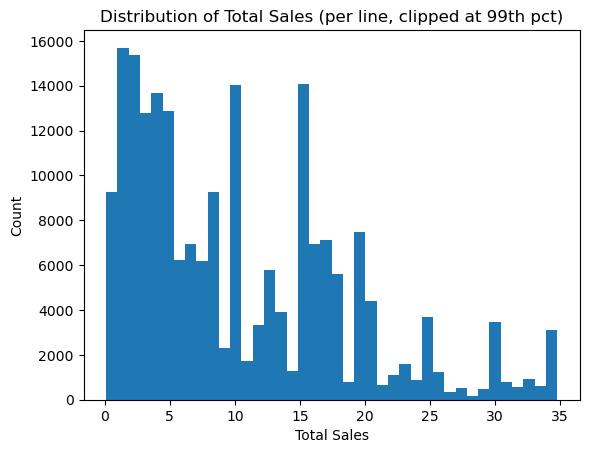

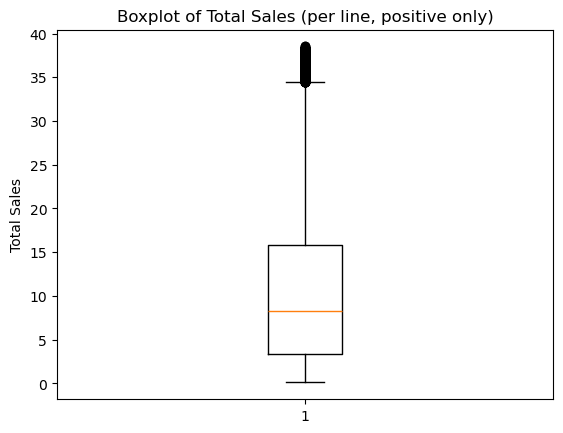

In [51]:

# ------------------------------------------------
# Use only positive sales for distribution; returns (negative) are often separate
pos_sales = df.loc[df["Total Sales"] > 0, "Total Sales"].copy()

# Clip extreme tail for clearer histogram (e.g., 99th percentile)
clip_hi = pos_sales.quantile(0.99) if len(pos_sales) else 0
pos_sales_clip = pos_sales.clip(upper=clip_hi)

print("Descriptive Stats for Positive Total Sales (per line):")
print(pos_sales.describe(percentiles=[0.5, 0.9, 0.95, 0.99]).round(2))

plt.figure()
plt.hist(pos_sales_clip, bins=40)
plt.title("Distribution of Total Sales (per line, clipped at 99th pct)")
plt.xlabel("Total Sales")
plt.ylabel("Count")
plt.show()

# Boxplot (shows spread & outliers)
plt.figure()
plt.boxplot(pos_sales)
plt.title("Boxplot of Total Sales (per line, positive only)")
plt.ylabel("Total Sales")
plt.show()

2) Average Purchase Size (AOV) — per order


Average Order Value (AOV): 279.97
Median Order Value: 191.59


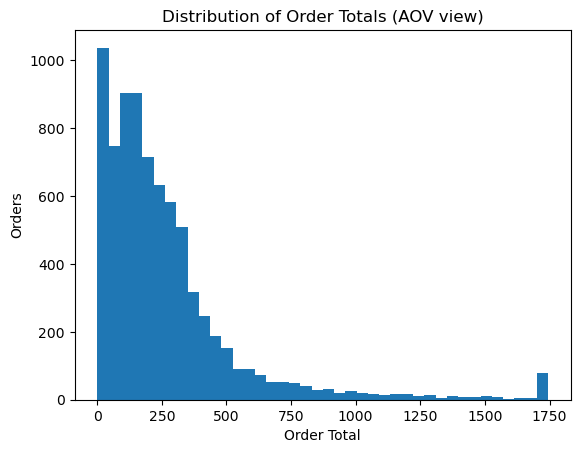

In [52]:

# ------------------------------------------------
# Order total = sum of line totals within an InvoiceNo
order_totals = (
    df.groupby(["InvoiceNo", "CustomerID"], dropna=False)["Total Sales"]
      .sum()
      .reset_index(name="OrderTotal")
)

AOV = order_totals["OrderTotal"].mean()
median_order = order_totals["OrderTotal"].median()
print(f"\nAverage Order Value (AOV): {AOV:.2f}")
print(f"Median Order Value: {median_order:.2f}")

plt.figure()
plt.hist(order_totals["OrderTotal"].clip(upper=order_totals["OrderTotal"].quantile(0.99)), bins=40)
plt.title("Distribution of Order Totals (AOV view)")
plt.xlabel("Order Total")
plt.ylabel("Orders")
plt.show()

3) Frequency of Transactions

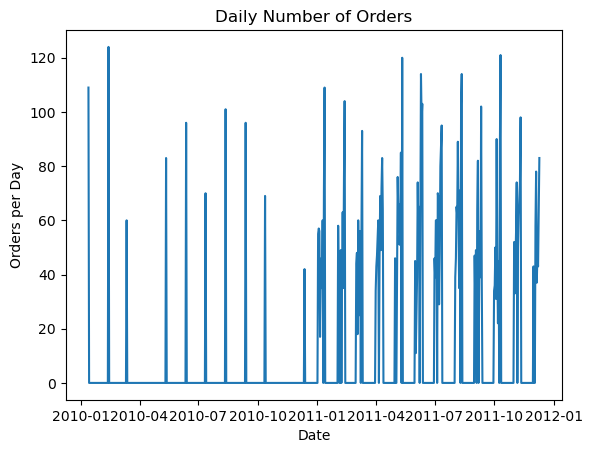

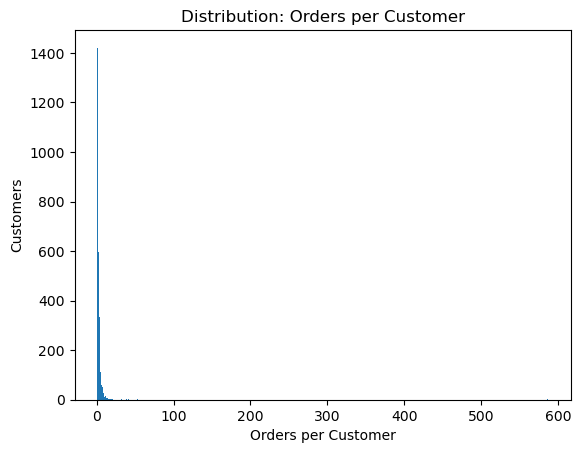

In [53]:

# ------------------------------------------------
# Daily transaction count
daily_txn = df.set_index("InvoiceDate").resample("D")["InvoiceNo"].nunique().rename("DailyOrders").reset_index()

plt.figure()
plt.plot(daily_txn["InvoiceDate"], daily_txn["DailyOrders"])
plt.title("Daily Number of Orders")
plt.xlabel("Date")
plt.ylabel("Orders per Day")
plt.show()

# Orders per customer (frequency distribution)
orders_per_customer = order_totals.groupby("CustomerID", dropna=False)["InvoiceNo"].nunique().rename("Orders").reset_index()

plt.figure()
plt.hist(orders_per_customer["Orders"], bins=range(1, orders_per_customer["Orders"].max()+2))
plt.title("Distribution: Orders per Customer")
plt.xlabel("Orders per Customer")
plt.ylabel("Customers")
plt.show()

4) Unique Customers over timeframe


Unique customers (entire dataset/timeframe): 2854


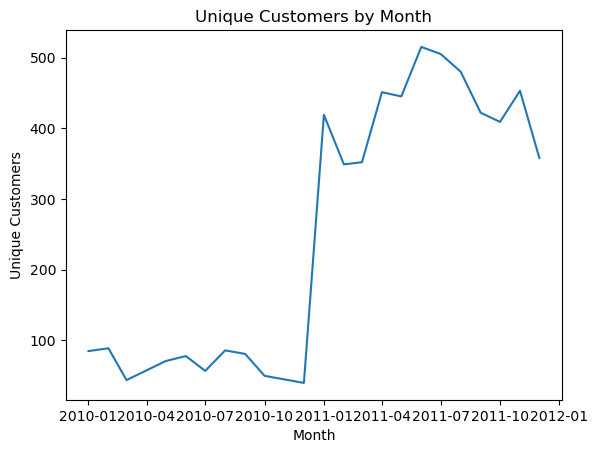

In [54]:

# ------------------------------------------------
unique_customers_total = df["CustomerID"].nunique()
print(f"\nUnique customers (entire dataset/timeframe): {unique_customers_total}")

# Unique by month
cust_by_month = df.groupby("Month")["CustomerID"].nunique().rename("UniqueCustomers").reset_index()

plt.figure()
plt.plot(pd.to_datetime(cust_by_month["Month"]), cust_by_month["UniqueCustomers"])
plt.title("Unique Customers by Month")
plt.xlabel("Month")
plt.ylabel("Unique Customers")
plt.show()

5) Revenue Trends (weekly, monthly, yearly)

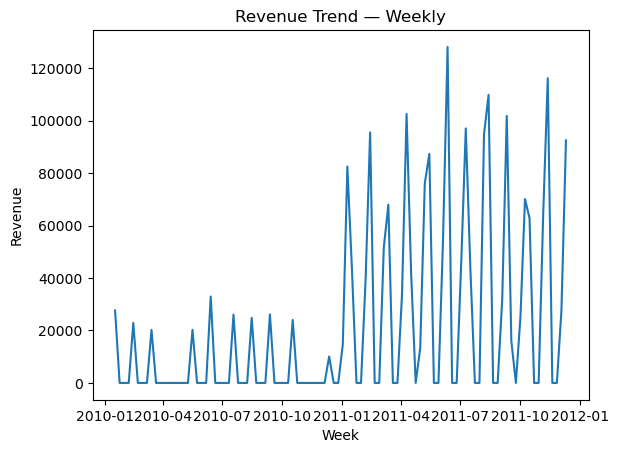

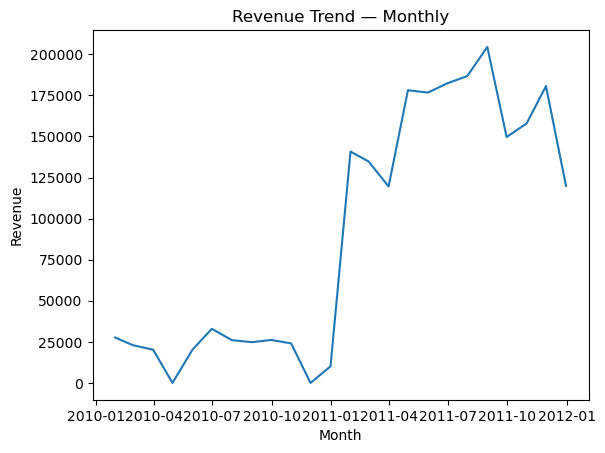

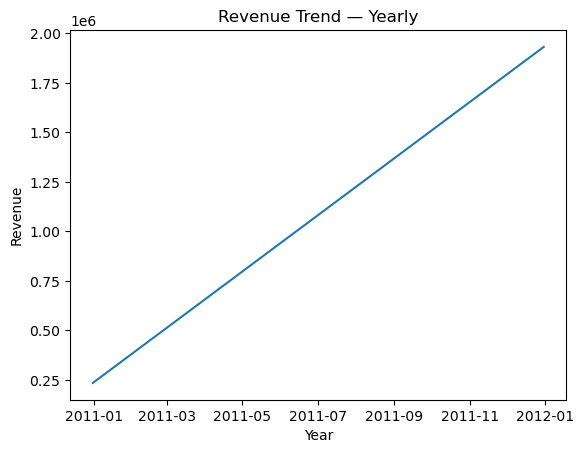

In [55]:

# ------------------------------------------------
weekly_rev = df.set_index("InvoiceDate").resample("W")["Total Sales"].sum().reset_index()
monthly_rev = df.set_index("InvoiceDate").resample("ME")["Total Sales"].sum().reset_index()  # Month-End
yearly_rev = df.set_index("InvoiceDate").resample("YE")["Total Sales"].sum().reset_index()  # Year-End

# Weekly Trend
plt.figure()
plt.plot(weekly_rev["InvoiceDate"], weekly_rev["Total Sales"])
plt.title("Revenue Trend — Weekly")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.show()

# Monthly Trend
plt.figure()
plt.plot(monthly_rev["InvoiceDate"], monthly_rev["Total Sales"])
plt.title("Revenue Trend — Monthly")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

# Yearly Trend
plt.figure()
plt.plot(yearly_rev["InvoiceDate"], yearly_rev["Total Sales"])
plt.title("Revenue Trend — Yearly")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.show()

 6) Seasonality & Purchase Behaviors

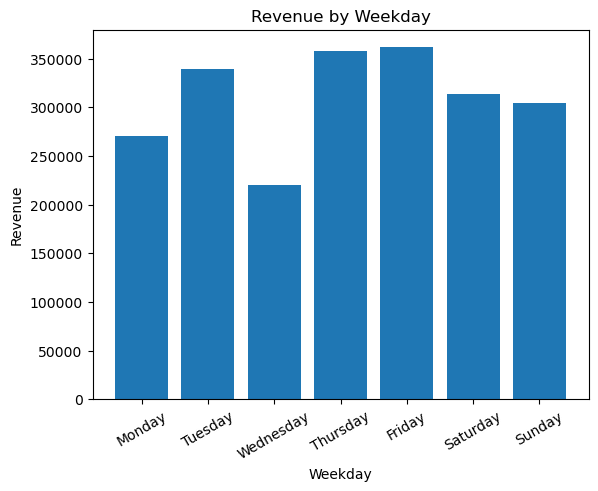

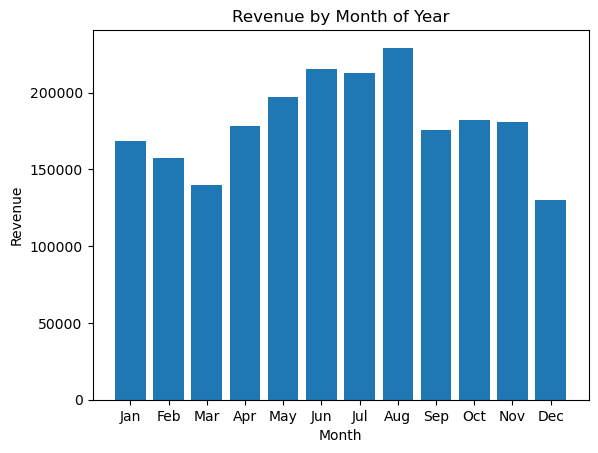

In [56]:

# ------------------------------------------------
# Weekday pattern
weekday_rev = df.groupby("Weekday")["Total Sales"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure()
plt.bar(weekday_rev.index, weekday_rev.values)
plt.title("Revenue by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Revenue")
plt.xticks(rotation=30)
plt.show()

# Month-of-year pattern
df["MonthName"] = df["InvoiceDate"].dt.strftime("%b")
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
moy_rev = df.groupby("MonthName")["Total Sales"].sum().reindex(month_order)

plt.figure()
plt.bar(moy_rev.index, moy_rev.values)
plt.title("Revenue by Month of Year")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

7) (Optional) Simple Category View from Description

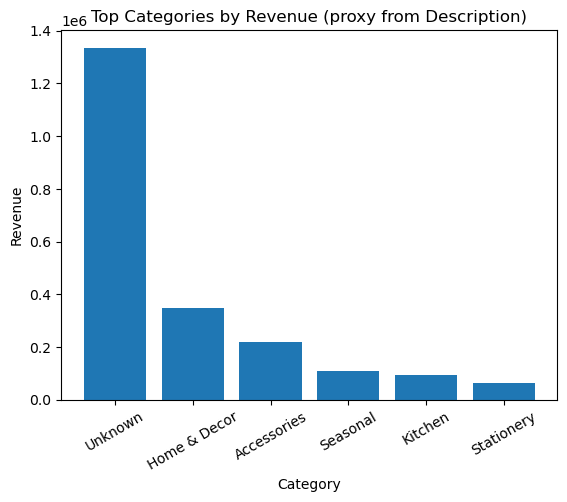

In [57]:

#     If you don't have Product Categories, build a quick proxy.
# ------------------------------------------------
CATEGORY_KEYWORDS = {
    "MUG": "Kitchen", "CUP": "Kitchen", "PLATE": "Kitchen",
    "BAG": "Accessories", "PURSE": "Accessories",
    "LANTERN": "Home & Decor", "CANDLE": "Home & Decor", "T-LIGHT": "Home & Decor",
    "HEART": "Home & Decor", "BOTTLE": "Home & Decor",
    "CHRISTMAS": "Seasonal", "TREE": "Seasonal", "GARLAND": "Seasonal",
    "CARD": "Stationery", "WRAP": "Stationery"
}

def to_category(desc: str) -> str:
    if not isinstance(desc, str):
        return "Unknown"
    u = desc.upper()
    for kw, cat in CATEGORY_KEYWORDS.items():
        if kw in u:
            return cat
    return "Unknown"

df["ProductCategory"] = df["Description"].apply(to_category)

cat_rev = (
    df.groupby("ProductCategory")["Total Sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure()
plt.bar(cat_rev.index.astype(str), cat_rev.values)
plt.title("Top Categories by Revenue (proxy from Description)")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.xticks(rotation=30)
plt.show()

8) Quick text summary

In [58]:

# ------------------------------------------------
print("\n====== Quick Summary ======")
print(f"Rows: {len(df):,}")
print(f"Distinct invoices (orders): {df['InvoiceNo'].nunique():,}")
print(f"Distinct customers: {df['CustomerID'].nunique():,}")
print(f"Total revenue: {df['Total Sales'].sum():.2f}")
print(f"AOV (mean order total): {AOV:.2f}")
print(f"Median order total: {median_order:.2f}")
print("Top 5 categories (proxy):")
print(cat_rev.head().round(2))


====== Quick Summary ======
Rows: 207,218
Distinct invoices (orders): 7,740
Distinct customers: 2,854
Total revenue: 2166988.28
AOV (mean order total): 279.97
Median order total: 191.59
Top 5 categories (proxy):
ProductCategory
Unknown         1335218.88
Home & Decor     348791.80
Accessories      217931.60
Seasonal         108651.23
Kitchen           93320.99
Name: Total Sales, dtype: float64


## **3) RFM Segmentation**

Q1) Calculate RFM Metrics for Each Customer

Recency = days since last purchase
Frequency = total transactions
Monetary = total revenue

In [59]:
import pandas as pd
import numpy as np

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Set observation date (one day after last purchase in dataset)
observation_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Calculate R, F, M
rfm = (
    df.groupby("CustomerID")
      .agg({
          "InvoiceDate": lambda x: (observation_date - x.max()).days,  # Recency
          "InvoiceNo": "nunique",                                     # Frequency
          "Total Sales": "sum"                                        # Monetary
      })
      .reset_index()
)

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "Total Sales": "Monetary"
}, inplace=True)

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12347.0       96          5   1785.43
1     12348.0      221          1     17.00
2     12350.0      312          1    294.40
3     12352.0      275          2    336.08
4     12355.0       97          1    224.80


Q2) Create RFM Scores (1–5 scale)

Using qcut to assign scores.

In [60]:
# Assign scores (1–5)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)   # Lower Recency = better
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

print(rfm[["CustomerID", "Recency", "R_Score", "Frequency", "F_Score", "Monetary", "M_Score"]].head())

   CustomerID  Recency  R_Score  Frequency  F_Score  Monetary  M_Score
0     12347.0       96        3          5        5   1785.43        5
1     12348.0      221        2          1        1     17.00        1
2     12350.0      312        1          1        1    294.40        3
3     12352.0      275        1          2        3    336.08        3
4     12355.0       97        3          1        1    224.80        2


Q3) Combine Scores into Single RFM Score

Like 555 (best), 111 (worst).

In [61]:
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

print(rfm[["CustomerID", "RFM_Score"]].head())

   CustomerID RFM_Score
0     12347.0       355
1     12348.0       211
2     12350.0       113
3     12352.0       133
4     12355.0       312


Q4) Cluster Customers into Segments

Example rules to classify customers.

In [62]:
def segment_customer(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4 and row["M_Score"] >= 4:
        return "Loyal Customer"
    elif row["R_Score"] >= 4 and row["F_Score"] <= 2:
        return "New Customer"
    elif row["R_Score"] <= 2 and row["F_Score"] >= 3:
        return "At Risk"
    elif row["R_Score"] == 1 and row["F_Score"] == 1 and row["M_Score"] == 1:
        return "Dormant"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

print(rfm[["CustomerID", "RFM_Score", "Segment"]].head())

   CustomerID RFM_Score  Segment
0     12347.0       355   Others
1     12348.0       211   Others
2     12350.0       113   Others
3     12352.0       133  At Risk
4     12355.0       312   Others


Q5) Segment Distribution Summary

How many customers are in each group


In [63]:
segment_summary = rfm["Segment"].value_counts()
print(segment_summary)

Segment
Others            1497
Loyal Customer     523
At Risk            481
New Customer       292
Dormant             61
Name: count, dtype: int64


Q6) Plot Segment Distribution

Visual representation.

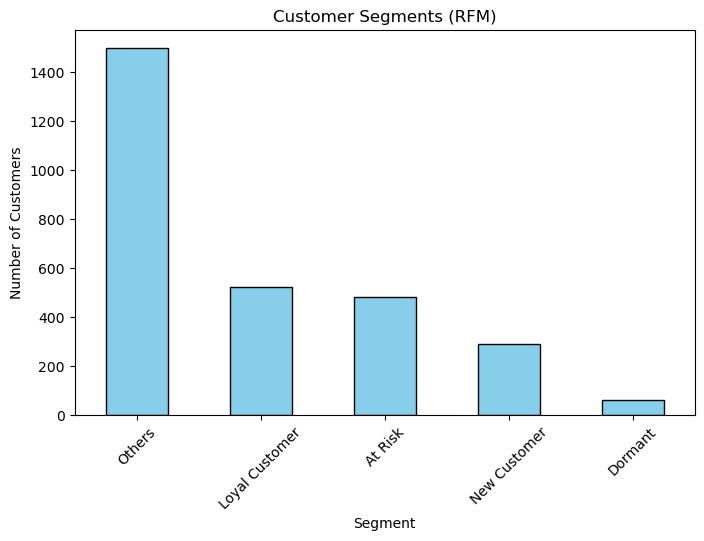

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
rfm["Segment"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Customer Segments (RFM)")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

Q7) RFM Heatmap (per Segment)

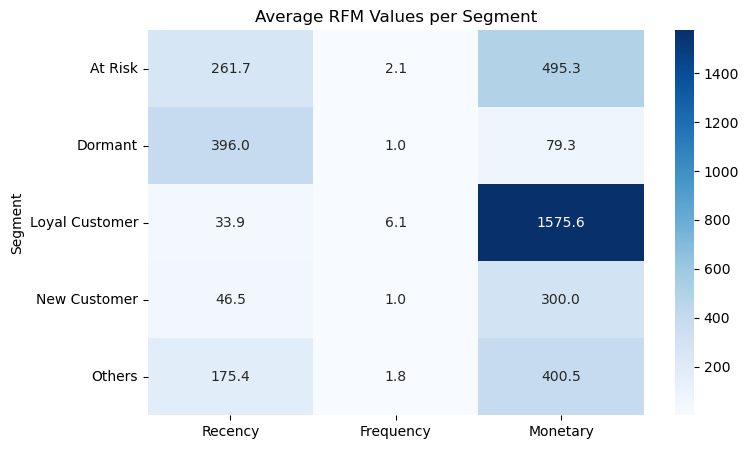

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by segment and calculate mean RFM values
rfm_summary = rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean().round(1)

# Create heatmap
plt.figure(figsize=(8,5))
sns.heatmap(rfm_summary, annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM Values per Segment")
plt.show()

## **4) Deciling Analysis**

1.Order totals per order, then per customer

In [66]:
orders = (
    df.groupby(["InvoiceNo","CustomerID"], dropna=False)["Total Sales"]
      .sum().reset_index(name="OrderTotal")
)

cust = (
    orders.groupby("CustomerID", dropna=False)
          .agg(TotalRevenue=("OrderTotal","sum"),
               Orders=("InvoiceNo","nunique"))
          .reset_index()
)

2.Revenue deciles (Decile 1 = Top 10%)

In [67]:
cust_rev = cust[["CustomerID","TotalRevenue"]].copy().sort_values("TotalRevenue")
cust_rev["RevenueDecile"] = pd.qcut(
    cust_rev["TotalRevenue"], q=10,
    labels=[f"Decile {i}" for i in range(10,0,-1)],   # 1 = top
    duplicates="drop"
)

rev_summary = (
    cust_rev.groupby("RevenueDecile", observed=False)["TotalRevenue"]
            .agg(count="count", mean="mean", sum="sum")
            .round(2).sort_index()
)
print("Revenue deciles summary:\n", rev_summary)

Revenue deciles summary:
                count     mean         sum
RevenueDecile                            
Decile 10        286    50.03    14309.77
Decile 9         285   115.46    32905.45
Decile 8         286   168.15    48090.53
Decile 7         285   234.95    66959.77
Decile 6         286   304.73    87151.95
Decile 5         285   387.68   110487.55
Decile 4         285   513.23   146270.86
Decile 3         286   717.32   205152.64
Decile 2         285  1090.81   310881.49
Decile 1         286  4002.72  1144778.27


3.Frequency deciles (Decile 1 = Most frequent)

In [68]:
import pandas as pd

# Function to assign deciles
def assign_deciles(s, q=10):
    k = min(q, s.nunique(), len(s))
    if k <= 1:
        return pd.Series(["Decile 1"]*len(s), index=s.index)
    return pd.qcut(s.rank(method="first"), q=k, labels=[f"Decile {i}" for i in range(k,0,-1)])

# Assign deciles
cust_freq = cust[["CustomerID","Orders"]].copy()
cust_freq["FreqDecile"] = assign_deciles(cust_freq["Orders"])

# Summarize and sort by decile
freq_summary = (cust_freq.groupby("FreqDecile", observed=True)["Orders"]
                        .agg(count="count", mean="mean", sum="sum")
                        .round(2)
                        .sort_index(ascending=True))

print(freq_summary)

            count   mean   sum
FreqDecile                    
Decile 10     286   1.00   286
Decile 9      285   1.00   285
Decile 8      286   1.00   286
Decile 7      285   1.00   285
Decile 6      286   1.02   293
Decile 5      285   2.00   570
Decile 4      285   2.00   570
Decile 3      286   2.93   839
Decile 2      285   3.95  1126
Decile 1      286  11.19  3200


4.Identify Top 10% and Bottom 10%

In [69]:
# Clean lists (drop NaN IDs and cast to int)
top_spenders     = cust_rev.loc[cust_rev["RevenueDecile"]=="Decile 1","CustomerID"].dropna().astype("int64").tolist()
bottom_spenders  = cust_rev.loc[cust_rev["RevenueDecile"]=="Decile 10","CustomerID"].dropna().astype("int64").tolist()
top_frequent     = cust_freq.loc[cust_freq["FreqDecile"]=="Decile 1","CustomerID"].dropna().astype("int64").tolist()
bottom_frequent  = cust_freq.loc[cust_freq["FreqDecile"]=="Decile 10","CustomerID"].dropna().astype("int64").tolist()

print("Top spenders (Decile 1):", top_spenders)
print("Bottom spenders (Decile 10):", bottom_spenders)
print("Most frequent (Decile 1):", top_frequent)
print("Least frequent (Decile 10):", bottom_frequent)

Top spenders (Decile 1): [12381, 14456, 15632, 15687, 14868, 17428, 12395, 17700, 16241, 16609, 15998, 14194, 16143, 15111, 17315, 18065, 16790, 16904, 12709, 17651, 12712, 16393, 15752, 13901, 13047, 16145, 17863, 16007, 15764, 15955, 17589, 17677, 15061, 13115, 13230, 16712, 14842, 16326, 17442, 12635, 13869, 13771, 13148, 17059, 12626, 16244, 14852, 12539, 12607, 14702, 16791, 16133, 12431, 16713, 14844, 16161, 12779, 17107, 18041, 16843, 13408, 18178, 17719, 15974, 13078, 13850, 16722, 17160, 18272, 15228, 12662, 14189, 16678, 14175, 12685, 12705, 14903, 14961, 14132, 15298, 17069, 17611, 15518, 12502, 17419, 17920, 15673, 16945, 17164, 12583, 14713, 15114, 13451, 14562, 13198, 12490, 13668, 14307, 16549, 12484, 14180, 15628, 13097, 17827, 15808, 12347, 12721, 13050, 14907, 12766, 16771, 12836, 17576, 17377, 15531, 16011, 16837, 14688, 17634, 14250, 16938, 15570, 12362, 12971, 16746, 14121, 12627, 17965, 17238, 14286, 12517, 14360, 16670, 13001, 18226, 13344, 13137, 12569, 12839, 1

In [70]:
import pandas as pd

# 1) Load your 9-column data
df = pd.read_csv("data_with_totals_9cols.csv", encoding="ISO-8859-1", parse_dates=["InvoiceDate"])

# 2) Order totals
orders = (df.groupby(["InvoiceNo","CustomerID"], as_index=False)["Total Sales"]
            .sum().rename(columns={"Total Sales":"OrderTotal"}))

# 3) Customer-level: Monetary (TotalRevenue) + Frequency (Orders)
cust = (orders.groupby("CustomerID", as_index=False)
              .agg(TotalRevenue=("OrderTotal","sum"),
                   Orders=("InvoiceNo","nunique")))

# 4) Recency (days since last purchase)
last_purchase = df.groupby("CustomerID", as_index=False)["InvoiceDate"].max().rename(columns={"InvoiceDate":"LastPurchaseDate"})
cust = cust.merge(last_purchase, on="CustomerID", how="left")
max_date = df["InvoiceDate"].max().normalize()
cust["RecencyDays"] = (max_date - cust["LastPurchaseDate"].dt.normalize()).dt.days

# 5) Safe deciles helper
def assign_deciles(s, q=10):
    k = min(q, s.nunique(), len(s))
    if k <= 1:  # all same values
        return pd.Series(["Decile 1"]*len(s), index=s.index)
    return pd.qcut(s.rank(method="first"), q=k, labels=[f"Decile {i}" for i in range(k,0,-1)])

cust["RevenueDecile"] = assign_deciles(cust["TotalRevenue"])
cust["FreqDecile"]    = assign_deciles(cust["Orders"])

# (Optional but nice) RFM 1–5 scores + label
cust["R_Score"] = pd.qcut(-cust["RecencyDays"].rank(method="first"), 5, labels=[1,2,3,4,5])
cust["F_Score"] = pd.qcut( cust["Orders"].rank(method="first"),     5, labels=[1,2,3,4,5])
cust["M_Score"] = pd.qcut( cust["TotalRevenue"].rank(method="first"),5, labels=[1,2,3,4,5])
cust["RFM_Segment"] = cust["R_Score"].astype(str)+cust["F_Score"].astype(str)+cust["M_Score"].astype(str)

# 6) Save for Power BI
df.to_csv("fact_sales.csv", index=False)
cust.to_csv("customer_segments.csv", index=False)
print("✅ Exported: fact_sales.csv, customer_segments.csv")


✅ Exported: fact_sales.csv, customer_segments.csv


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
